# Rotations and transmission lines

On a lossless transmission line, moving along the line changes the phase of the reflection coefficient.

If the load reflection coefficient is $\Gamma_L$, then at a distance $l$ from the load (toward the generator):

$$
\Gamma(l) = \Gamma_L e^{-j 2 \beta l}
$$

where $\beta = 2\pi/\lambda$.

Key implications:

- **Moving along the line rotates $\Gamma$**.
- The rotation is **clockwise** when moving **toward the generator** (decreasing phase).
- The pattern is **half-wavelength periodic** because of the factor $2\beta l$.

This notebook shows how to visualize these ideas on a Smith chart using `pysmithchart`.

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

import pysmithchart
from pysmithchart.constants import REFLECTANCE_DOMAIN, IMPEDANCE_DOMAIN, ABSOLUTE_DOMAIN
from pysmithchart import utils

text_box = dict(facecolor="lightyellow")

## 1. Rotation in the $\Gamma$ plane (REFLECTANCE_DOMAIN)

In `REFLECTANCE_DOMAIN`, the Smith chart data are literally $\Gamma$.
So moving along the line is a simple complex rotation.

We start with a load reflection coefficient $\Gamma_L$ and rotate it by a sequence of electrical lengths.

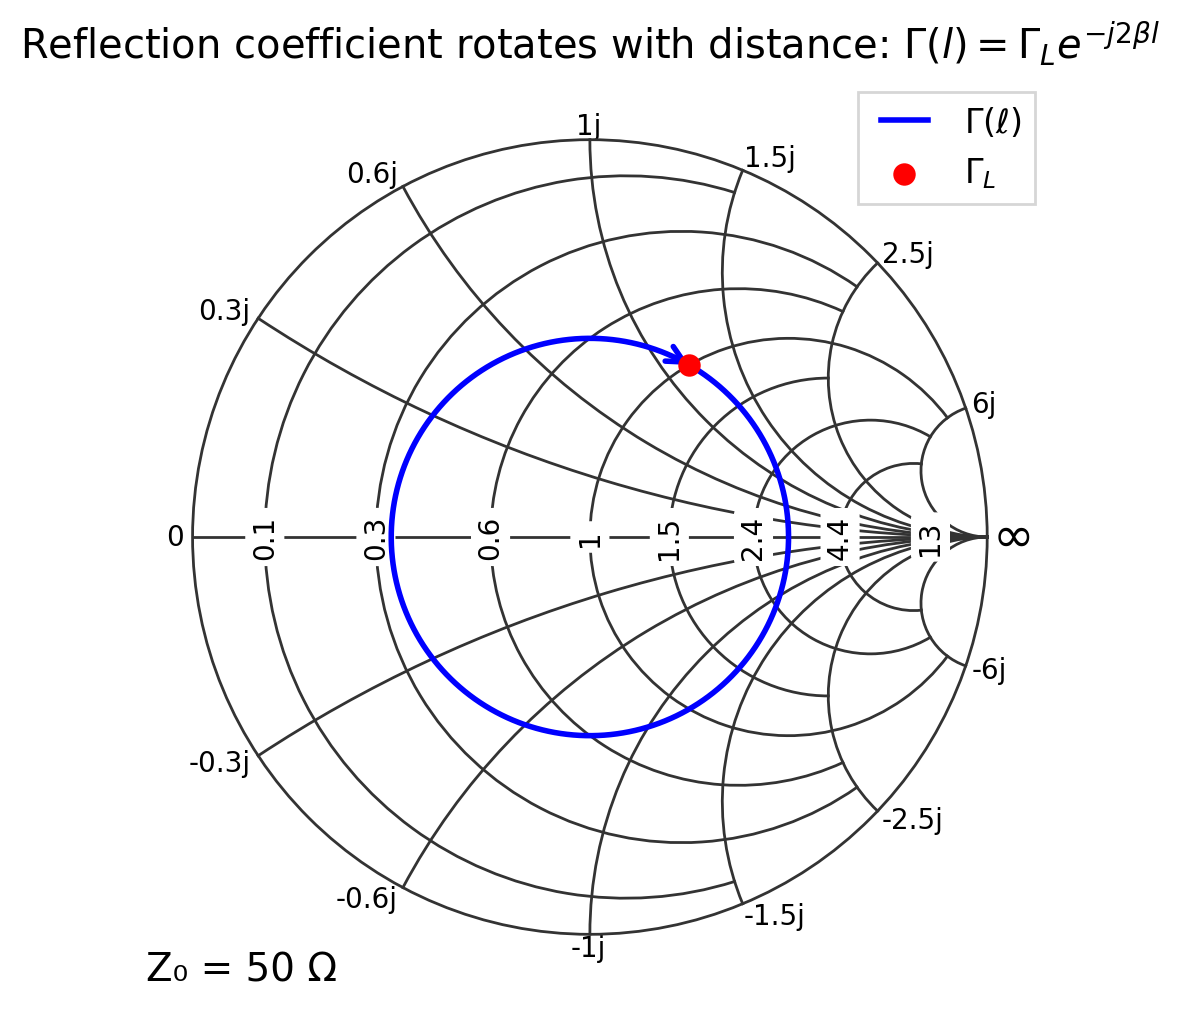

In [2]:
Gamma_L = 0.5 * np.exp(1j * np.deg2rad(60))  # example load reflection coefficient
ell_over_lambda = np.linspace(0, 0.5, 201)  # 0 to half-wavelength

# Toward generator: Gamma(l) = Gamma_L * exp(-j 4 pi (ell/lambda))
Gamma = Gamma_L * np.exp(-1j * 4 * np.pi * ell_over_lambda)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma, "b", label=r"$\Gamma(\ell)$", arrow="end")
ax.scatter(Gamma_L, c="r", s=50, label=r"$\Gamma_L$")

ax.legend(loc="upper right")
ax.set_title(r"Reflection coefficient rotates with distance: $\Gamma(l)=\Gamma_L e^{-j2\beta l}$")
plt.show()

### Direction: toward generator is clockwise

If we parameterize $l$ increasing from the load toward the generator, the exponential term $e^{-j2\beta l}$ rotates **clockwise**.

We will label a few points at eighth-wave intervals.

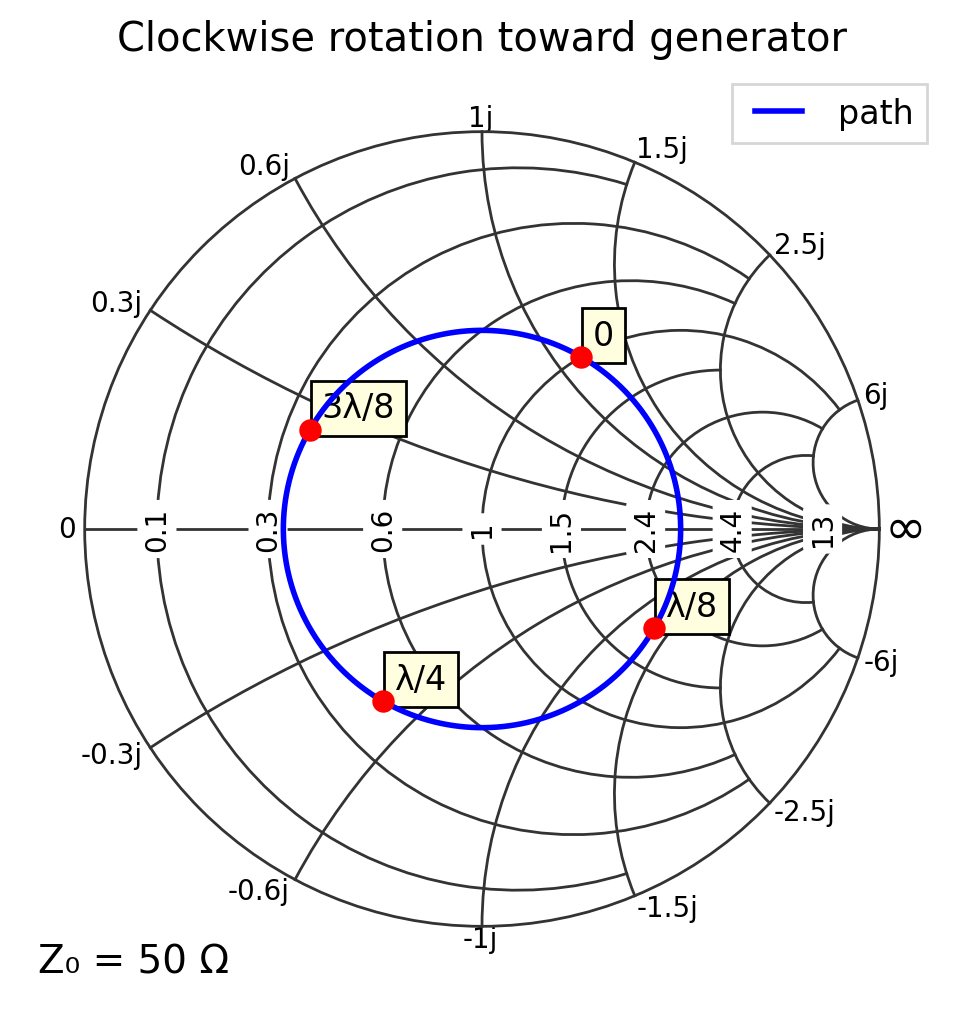

In [3]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma, "b", label="path")

text_offset = 0.03 + 0.03j
for frac, label in [(0.0, "0"), (0.125, "λ/8"), (0.25, "λ/4"), (0.375, "3λ/8")]:
    Gp = Gamma_L * np.exp(-1j * 4 * np.pi * frac)
    ax.scatter(Gp, c="r", s=50)
    ax.text(Gp + text_offset, label, bbox=text_box)

ax.legend(loc="upper right")
ax.set_title("Clockwise rotation toward generator")
plt.show()

## Half-wavelength periodicity

Because the phase rotation is $2\beta \ell$, moving by $\lambda/2$ produces a $2\pi$ phase change in $\Gamma$:

$$
\Gamma\left(\ell+\frac{\lambda}{2}\right) = \Gamma(\ell)
$$

So the impedance pattern repeats every half-wavelength along a lossless line.

We can show this by plotting $\Gamma(\ell)$ from 0 to $\lambda$, and noting the path is traced twice.

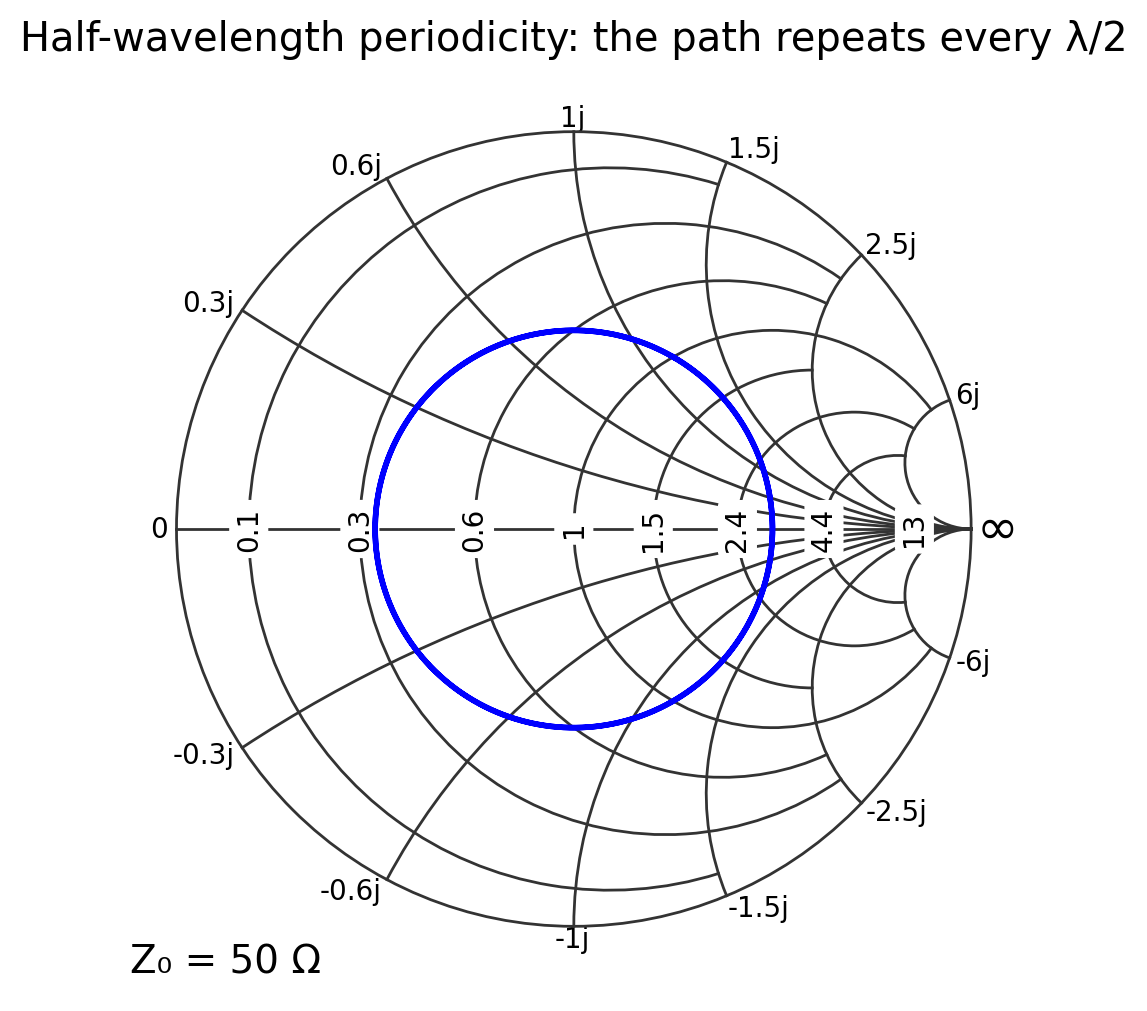

In [4]:
l_over_lambda2 = np.linspace(0, 1.0, 401)
Gamma2 = Gamma_L * np.exp(-1j * 4 * np.pi * l_over_lambda2)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma2, "b")
ax.set_title("Half-wavelength periodicity: the path repeats every λ/2")
plt.show()

## The same motion in impedance coordinates (IMPEDANCE_DOMAIN)

Many engineers think in terms of impedance $Z$ rather than $\Gamma$.
We can convert $\Gamma(\ell)$ into the corresponding input impedance:

$$
Z(l) = Z_0 \frac{1+\Gamma(\ell)}{1-\Gamma(\ell)}
$$

In the default `IMPEDANCE_DOMAIN`, `pysmithchart` expects impedances in ohms and normalizes internally by $Z_0$.

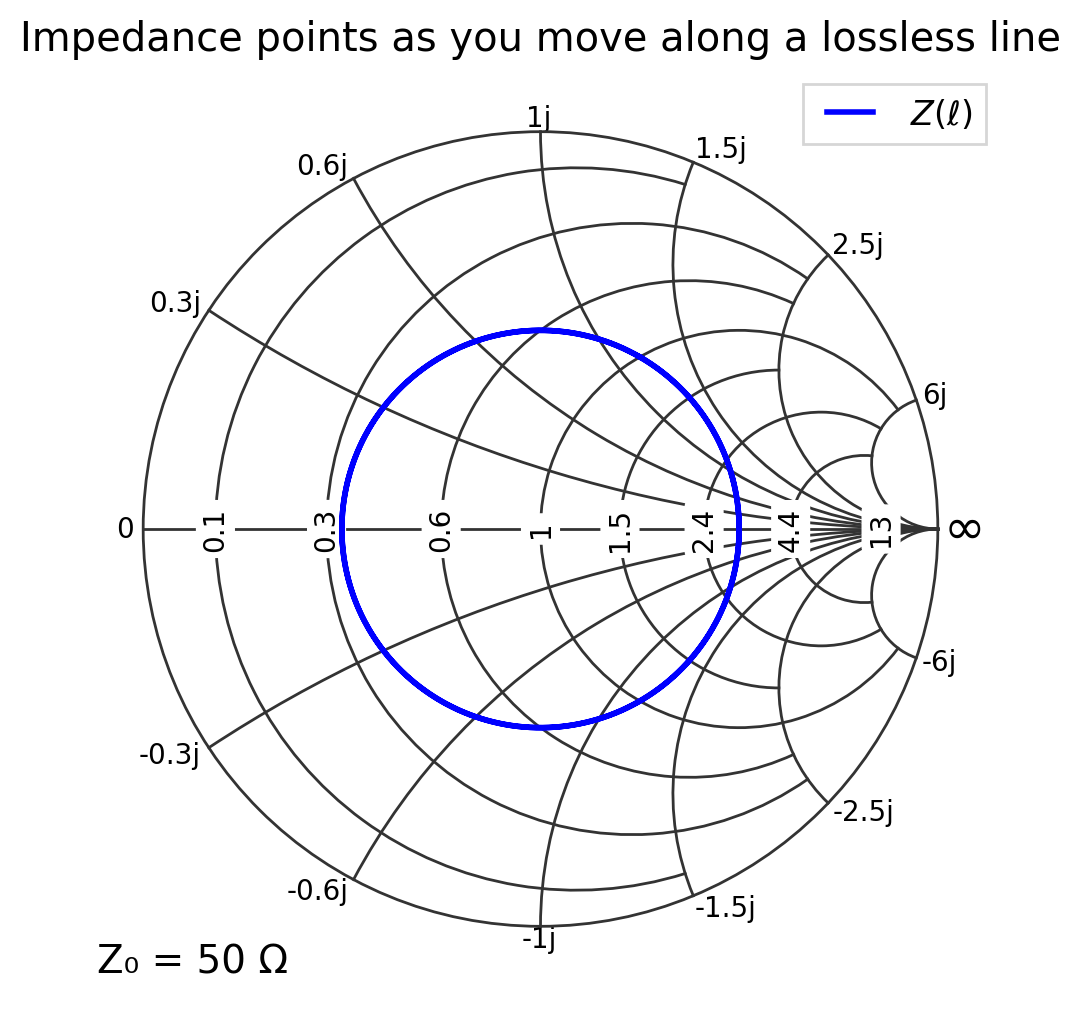

In [5]:
Z0 = 50
l_over_lambda2 = np.linspace(0, 1.0, 401)
Gamma2 = Gamma_L * np.exp(-1j * 4 * np.pi * l_over_lambda2)
Z_in = utils.calc_load(Z0, Gamma2)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot(Z_in, "b", label=r"$Z(\ell)$")
ax.legend(loc="upper right")
ax.set_title("Impedance points as you move along a lossless line")
plt.show()

## Rotate “toward generator” vs “toward load”

The sign convention matters.

- Toward generator: $\Gamma(l) = \Gamma_L e^{-j2\beta l}$
- Toward load: $\Gamma(l) = \Gamma_L e^{+j2\beta l}$

If your path appears to rotate the “wrong way,” check your direction and sign convention.

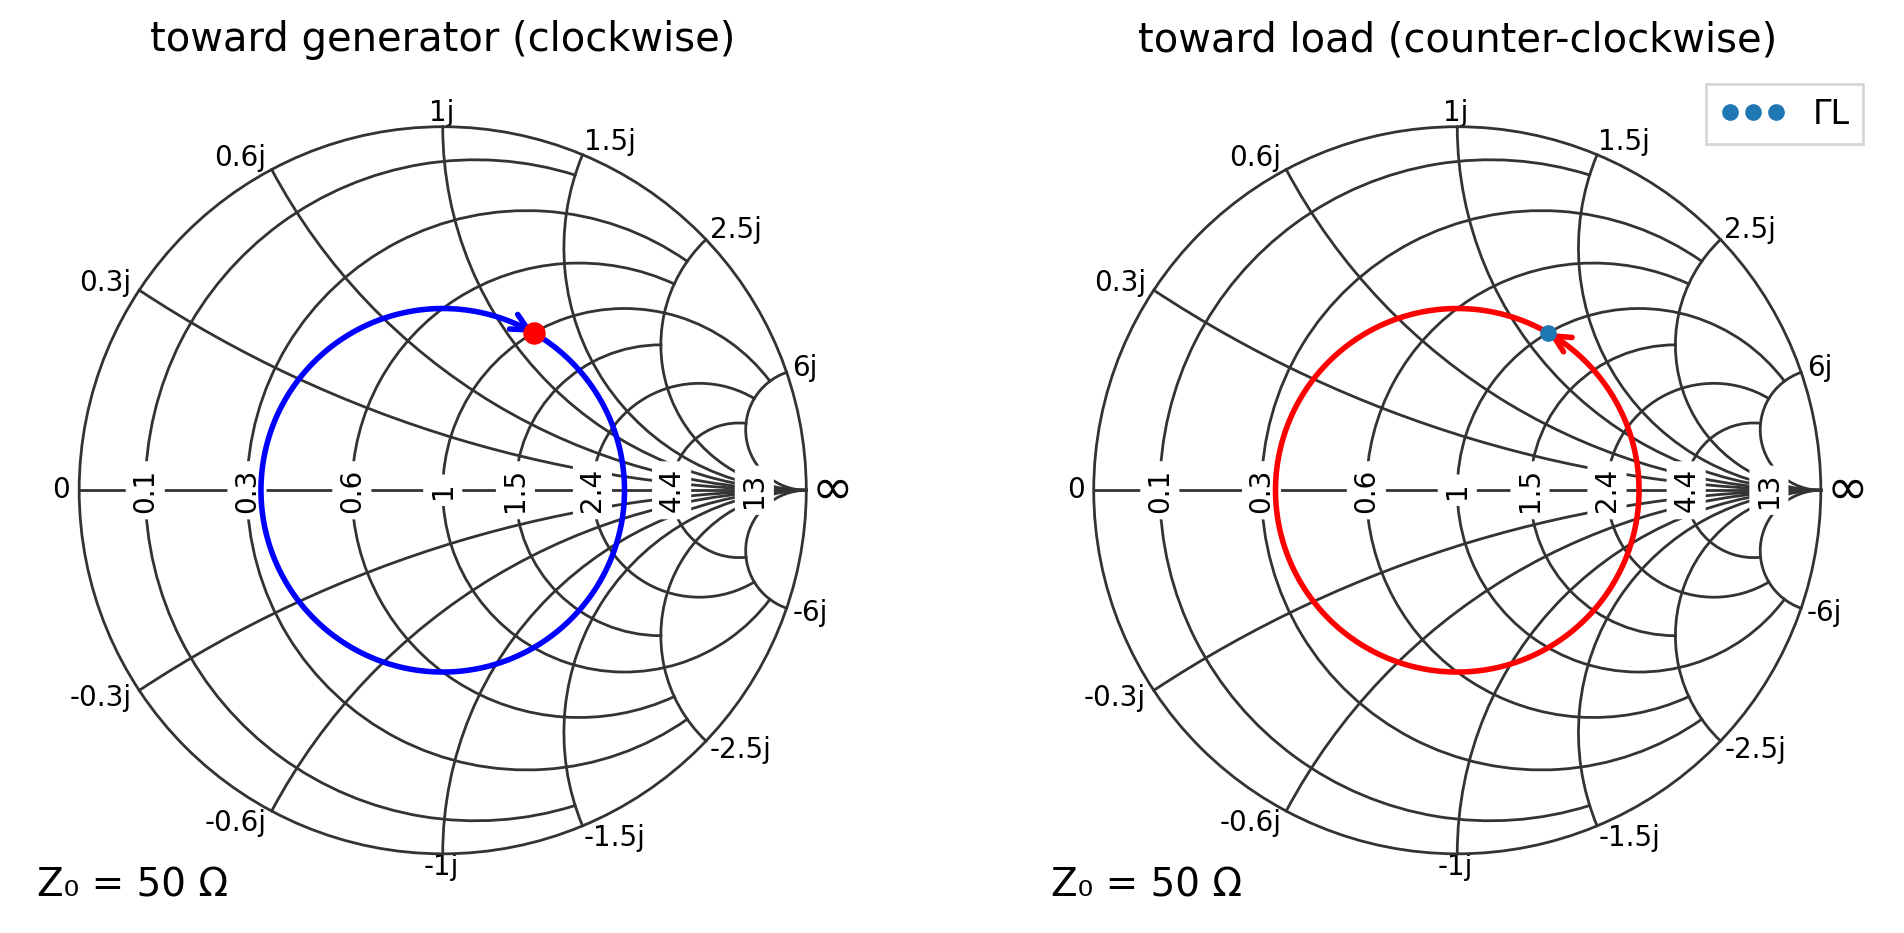

In [6]:
Gamma_L = 0.5 * np.exp(1j * np.deg2rad(60))  # example load reflection coefficient
ell = np.linspace(0, 0.5, 201)

Gamma_toward_gen = Gamma_L * np.exp(-1j * 4 * np.pi * ell)
Gamma_toward_load = Gamma_L * np.exp(+1j * 4 * np.pi * ell)

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma_toward_gen, "b", arrow=True)
ax.scatter(Gamma_L, c="r", s=50)
ax.set_title("toward generator (clockwise)")

ax = plt.subplot(122, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma_toward_load, "r", arrow=True)
ax.plot(Gamma_L, "o", label="ΓL")

ax.legend(loc="upper right")
ax.set_title("toward load (counter-clockwise)")
plt.show()

## Quarter-wave transformer example

A classic result: a lossless quarter-wave section transforms impedances according to:

$$
Z_{\mathrm{in}} = \frac{Z_0^2}{Z_L}
$$

This is the special case of the general transmission-line input impedance formula when $\ell=\lambda/4$.

We can compute this by rotating $\Gamma$ by $180^\circ$ (since $2\beta(\lambda/4) = \pi$) and converting back to impedance.

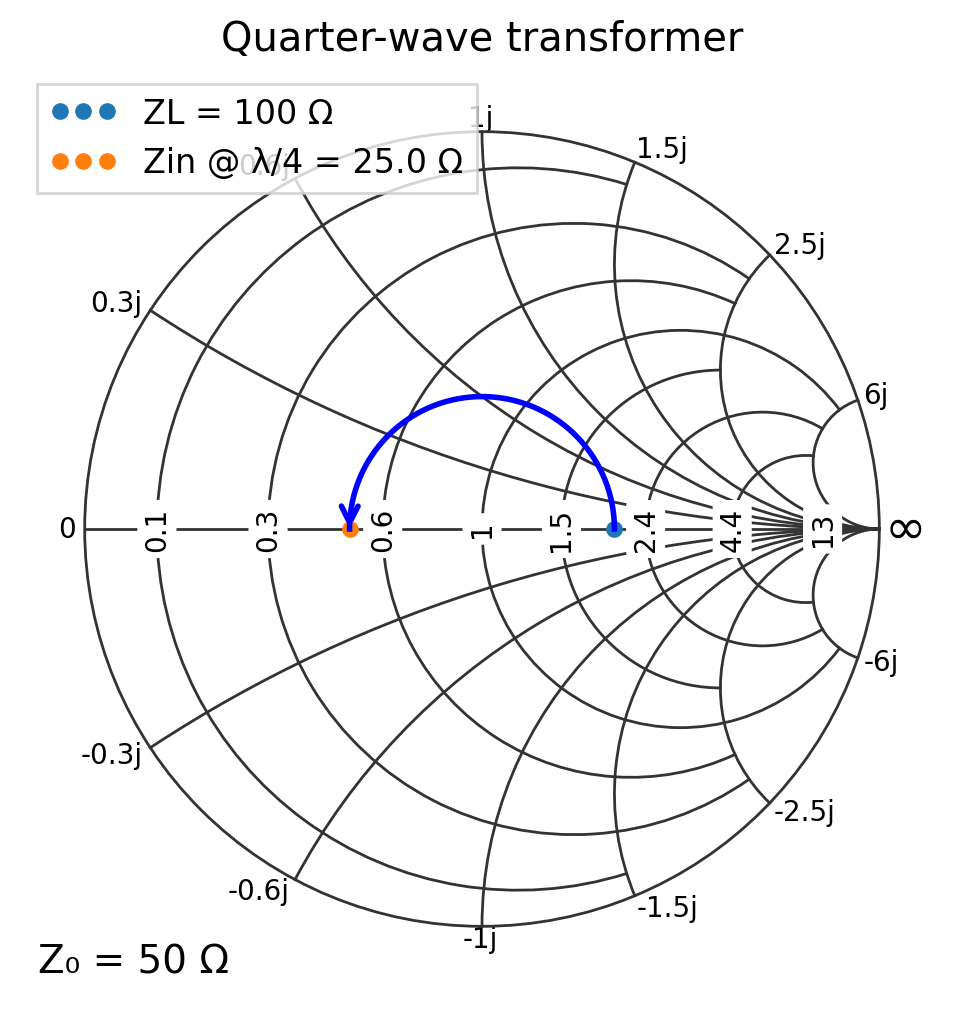

In [7]:
Z0 = 50
ZL = 100 + 0j
Gamma_L = utils.calc_gamma(Z0, ZL)

# Quarter-wave toward generator: rotate Gamma by -pi
Gamma_qw = Gamma_L * np.exp(-1j * np.pi)
Zin_qw = utils.calc_load(Z0, Gamma_qw)

vswr = utils.calc_vswr(Z0, ZL)
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot([ZL], "o", label=f"ZL = {ZL.real:.0f} Ω")
ax.plot([Zin_qw], "o", label=f"Zin @ λ/4 = {Zin_qw.real:.1f} Ω")
ax.plot_vswr(vswr, "b", angle_range=(0, 180), arrow="end")

ax.legend(loc="upper left")
ax.set_title("Quarter-wave transformer")
plt.show()